<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Прогнозирование количества заказов такси на следующий час

Требуется спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

Импортируем нужные нам библиотеки.

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

Считаем данные из csv-файла в датафрейм и сохраним в переменную `df`. Изменим типа данных `datetime` с `object` на `datetime64`. Также установим индекс таблицы равным столбцу `datetime`

In [3]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Выведим первые 5 и последние 5 строчек датафрейма

In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Проверим, что данных расположены в хронологическом порядке. 

In [5]:
df.index.is_monotonic

True

Выведим основную информацию о датафрейме с помощью метода `info()`.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выведим количество пропущенных значений в датафрейме.

In [7]:
df.isna().sum()

num_orders    0
dtype: int64

**Вывод:** загрузили данные, установили индекс по дате времени. Проверили на пропуски и расположение в хронологическом порядке. С данными всё в порядке

## Анализ

Построим график временного ряда

<AxesSubplot:xlabel='datetime'>

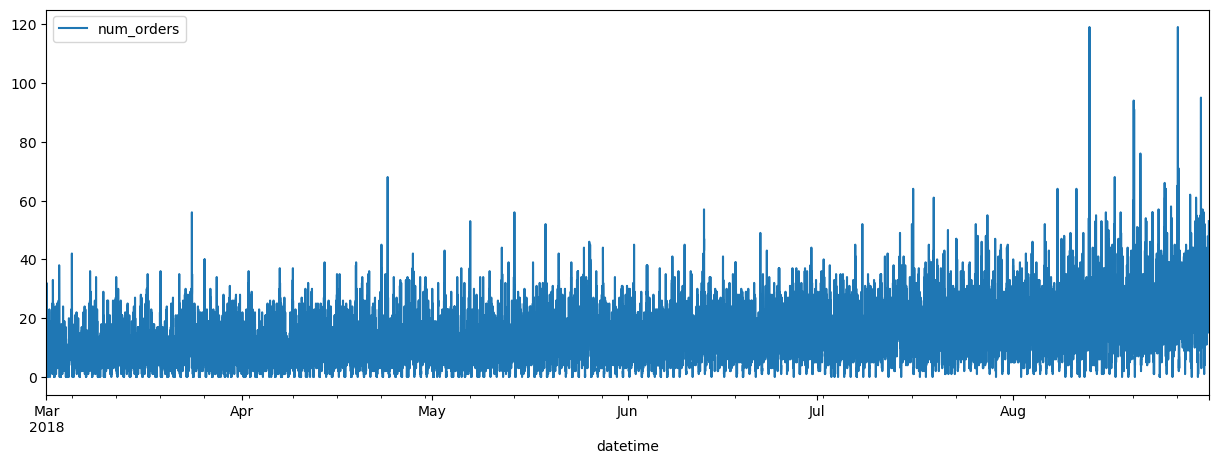

In [8]:
df.plot(figsize=(15, 5))

Так как задача в прогнозировании заказов на следующий час, ресемплилурем данные по часу

In [9]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

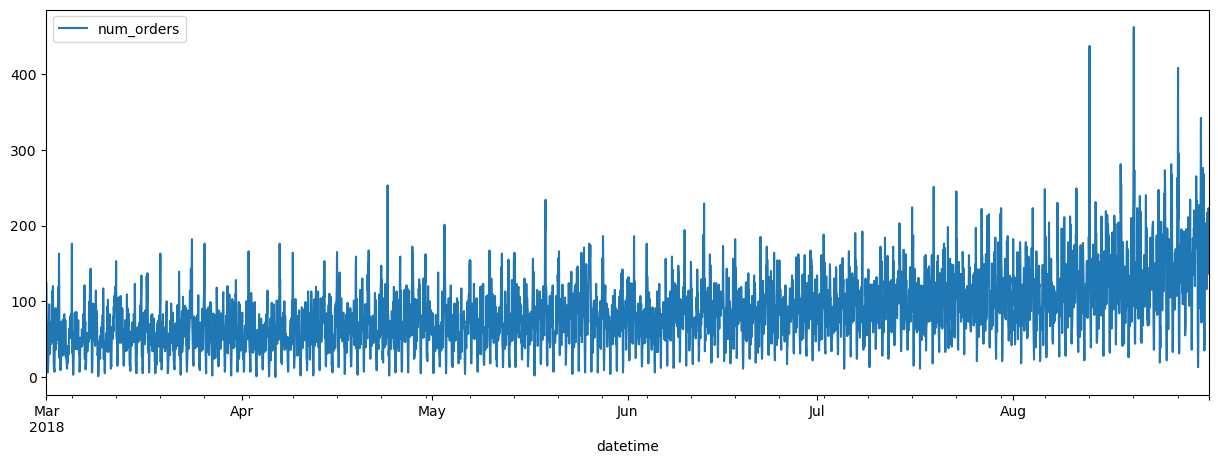

In [10]:
df.plot(figsize=(15, 5))

Проанализируем тренд

Text(0.5, 1.0, 'Trend')

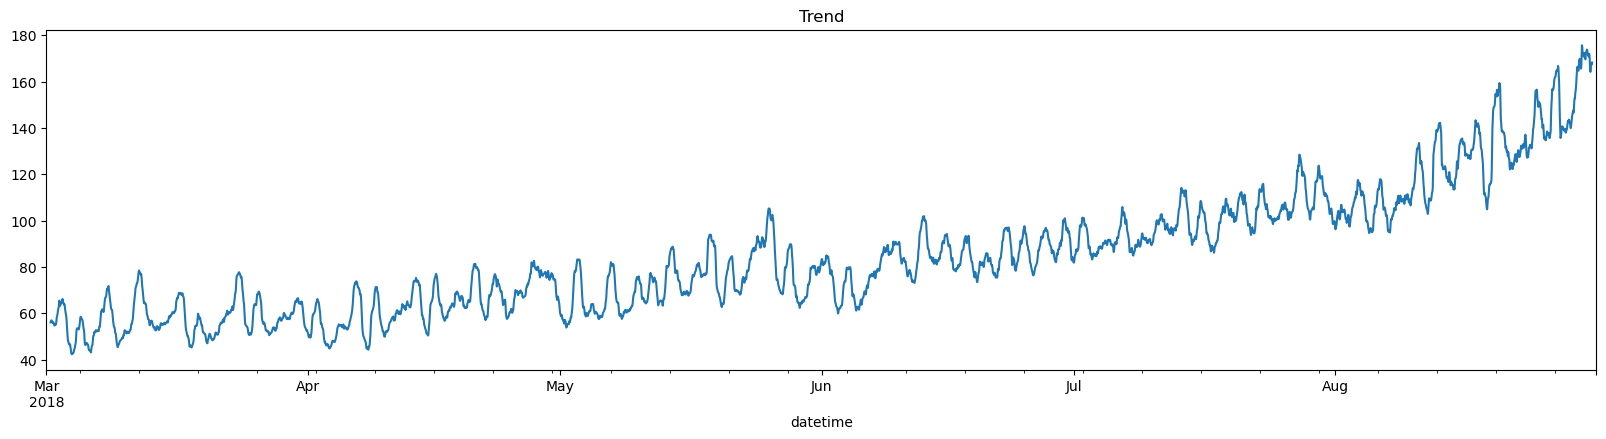

In [11]:
plt.figure(figsize=(20, 15))
plt.subplot(311)
seasonal_decompose(df).trend.plot(ax=plt.gca())
plt.title('Trend')

Количество заказов увеличивается с июля 

Посмотрим на сезонность

Text(0.5, 1.0, 'Seasonality')

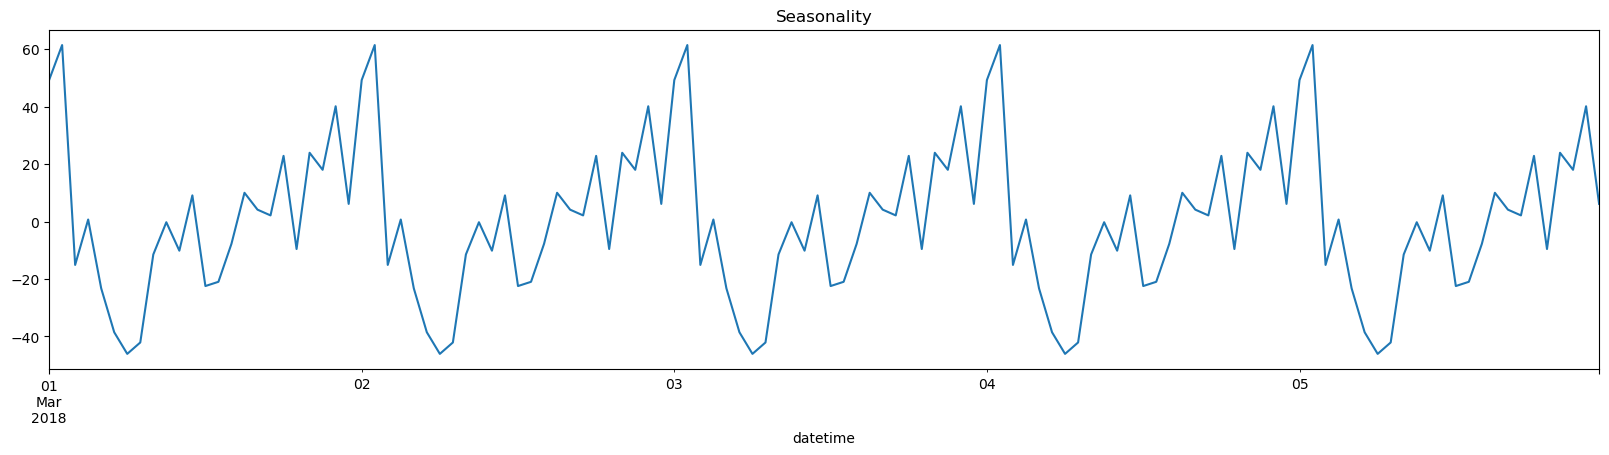

In [12]:
plt.figure(figsize=(20, 15))
plt.subplot(312)
seasonal_decompose(df['2018-03-01':'2018-03-5']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

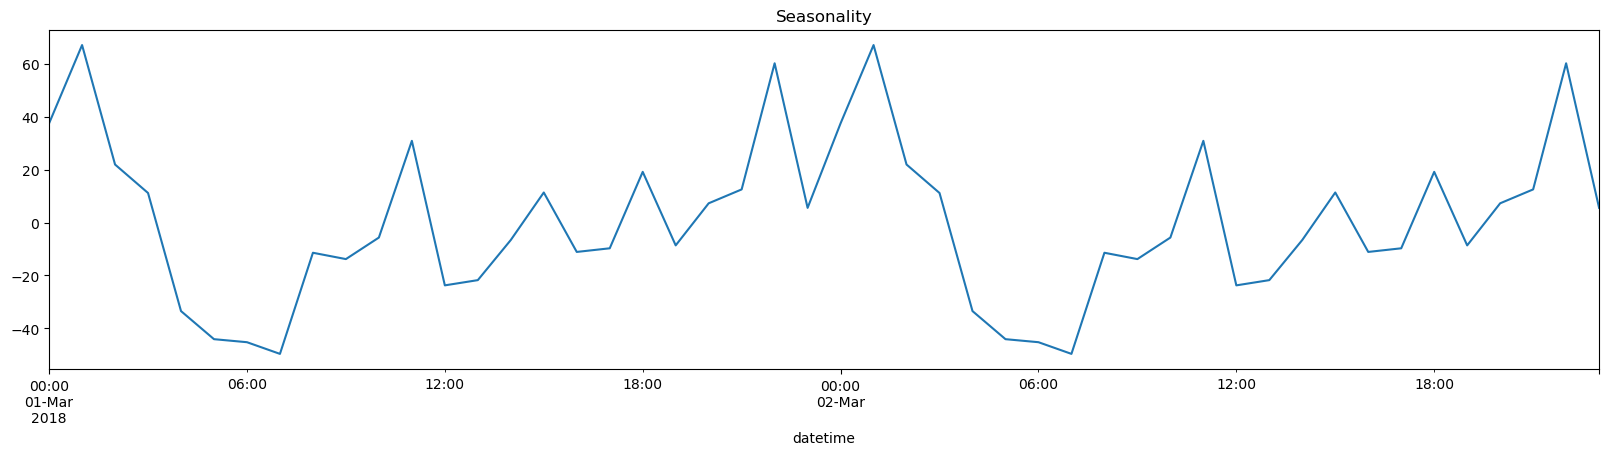

In [13]:
plt.figure(figsize=(20, 15))
plt.subplot(312)
seasonal_decompose(df['2018-03-01':'2018-03-2']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Можно увидеть, что количество заказов больше всего наблюдается с 00:00 по 02:00

## Обучение

Напишем функцию, которая создаёт календарные признаки, отстающие значения и скользящее среднее.

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [15]:
df = make_features(df, 20, 50)

Разобъём данные, оставим на валидационную и тестовую выборки по 10%. 

In [16]:
df = df.dropna()
train, test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
features_test.shape, features_train.shape

((437, 23), (3929, 23))

Обучим модель линейной регресии

In [18]:
cv_time_series = TimeSeriesSplit()

In [19]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

model = LinearRegression()
model.fit(features_train, target_train)
scores = cross_val_score(model, features, target, cv=cv_time_series, scoring="neg_root_mean_squared_error") 
final_score = scores.mean()
print(f'Качество модели линейной регрессии RMSE:', -final_score)

Качество модели линейной регрессии RMSE: 32.74038425174412


Обучим LGB модель и подберём лучшие параметры

In [20]:
cv_time_series = TimeSeriesSplit()

In [21]:
%%time
parametrs = { 
              'max_depth': [6, 7, 8],
              'learning_rate': [0.3, 0.2, 0.1],          
             }

lgb_model = LGBMRegressor()
grid_LGBM = GridSearchCV(lgb_model, parametrs, cv=cv_time_series, scoring="neg_root_mean_squared_error")
grid_LGBM.fit(features_train, target_train)

Wall time: 2 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.3, 0.2, 0.1],
                         'max_depth': [6, 7, 8]},
             scoring='neg_root_mean_squared_error')

In [22]:
print(f'Качество LGBM модели RMSE:', -grid_LGBM.cv_results_["mean_test_score"][0])

Качество LGBM модели RMSE: 25.914292896070453


**Вывод:** Лучше качество у LGBM модели. Тестироваться будем на ней

## Тестирование

In [23]:
predictions = grid_LGBM.predict(features_test)
print(f'Качество LGBM модели RMSE на тестовой выборке:', mean_squared_error(target_test, predictions) ** 0.5)

Качество LGBM модели RMSE на тестовой выборке: 43.20933025496387


Посмотрим на график исходного и предсказанного ряда

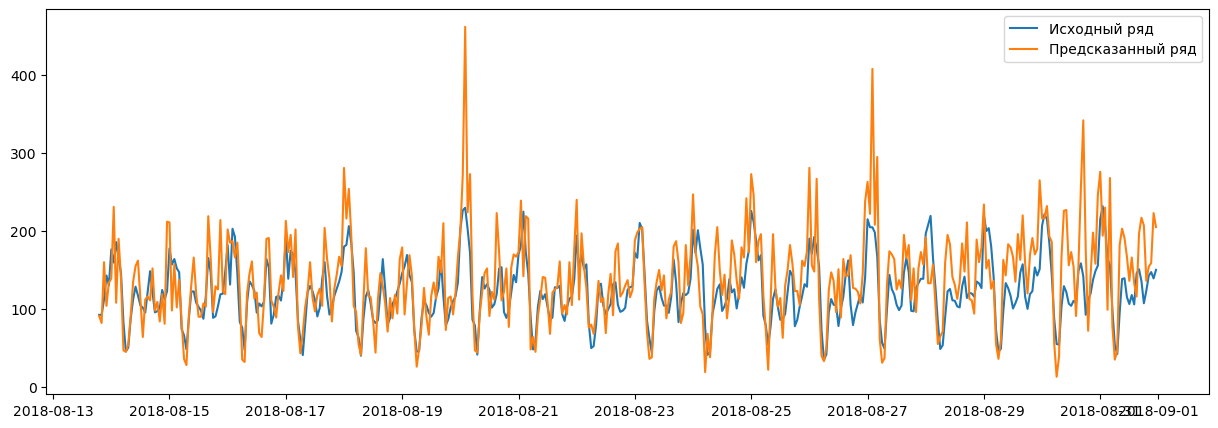

In [24]:
predictions = pd.DataFrame(predictions, index=features_test.index)
plt.figure(figsize=(15, 5))
plt.plot(predictions)
plt.plot(target_test)
plt.legend(['Исходный ряд', 'Предсказанный ряд'])
plt.show()

## Общий вывод

1) Загрузили данные, проверили на пропуски и расположение в хронологическом порядке

2) Проанализировали тренд и сезонность данных. Заметили, что больше всего заказывают такси с 00:00 по 02:00

3) Добавили в данные новые признаки. 

4) Обучили модель линейной регресии и LGBM. 

5) Проверили модели на тестовой выборке. Лучший результат показала LGBM - значение RMSE 30.656439348754567